   Copyright 2020 Erik Lee

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

In [1]:
import os
import zipfile
import random
import shutil
from shutil import copyfile
import cv2.cv2 as cv2

import tensorflow as tf
import numpy as np
import matplotlib as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from stn import spatial_transformer_network as transformer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
from tensorflow.keras.applications import InceptionV3

i_s = 128
tf.keras.backend.clear_session()
%precision 4

'%.4f'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    try:
        for cpu in cpus:
            tf.config.experimental.set_memory_growth(cpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(i_s,i_s,3)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation="relu"),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation="relu"),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation="softmax")
    ])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0

In [4]:

# model.add(tf.keras.layers.Dense(1024, activation="relu"))

# model.add(tf.keras.layers.Dense(512, activation="relu"))

# model.add(tf.keras.layers.Dense(7, activation="softmax"))

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(20, (2,2), activation="relu", input_shape=(64,64,3), strides=2),
#     tf.keras.layers.MaxPool2D(2,2),
#     tf.keras.layers.Conv2D(50, (2,2), activation="relu", strides=2),
#     tf.keras.layers.MaxPool2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(500, activation="relu"),
#     tf.keras.layers.Dense(7, activation="softmax"),
# ])
# model.summary()

In [5]:
# model_inception = InceptionV3(include_top=False, 
#                     weights=None, 
#                     input_shape=(256,256,3))

# for layer in model_inception.layers:
#     layer.trainable = False

# model_inception.summary()

In [6]:
# last_layer = model_inception.get_layer("mixed7")

# last_output = last_layer.output
# print(last_output)

In [7]:
# X = layers.Flatten()(last_output)

# X = layers.Dense(1024, activation="relu")(X)

# X = layers.Dense(7, activation="softmax")(X)

# model = Model(model_inception.input, X)

In [8]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['acc'])

In [9]:
def convert_to_grayscale(img):
      return tf.image.rgb_to_grayscale(img, name=None)
# the preprocess function assumes 1 argument, the image, you do not need to add that inline
# validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=convert_to_grayscale,)

TRAINING_DIR = "emotions/train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      horizontal_flip=True)
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, target_size=(i_s,i_s), 
batch_size=32, class_mode="categorical")

VALIDATION_DIR = "emotions/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=(i_s,i_s),batch_size=64, class_mode="categorical")



Found 25226 images belonging to 7 classes.
Found 5436 images belonging to 7 classes.


Bonnie_surprise_1389 image was corrupt, had to be removed

In [10]:
check_points = "checkpoint/checkpoint.hb/"
check_point_dir = os.path.dirname(check_points)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_dir, verbose=1, monitor="val_acc", save_best_only=True)

In [11]:
## Load checkpoint model
# model = tf.keras.models.load_model("checkpoint/checkpoint.hb/")

In [12]:
history = model.fit(train_generator,
                            epochs=15,
                            verbose=1,  
                            validation_data=validation_generator,
                            callbacks=[cp_callback])

Epoch 1/15
788/789 [============================>.] - ETA: 0s - loss: 1.6193 - acc: 0.3774
Epoch 00001: val_acc improved from -inf to 0.31770, saving model to checkpoint/checkpoint.hb
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoint/checkpoint.hb\assets
789/789 [==============================] - 33s 41ms/step - loss: 1.6189 - acc: 0.3775 - val_loss: 1.8109 - val_acc: 0.3177
Epoch 2/15
788/789 [============================>.] - ETA: 0s - loss: 1.3422 - acc: 0.4870
Epoch 00002: val_acc improved from 0.31770 to 0.41483, saving model to checkpoint/checkpoint.hb
INFO:tensorflow:Assets written to: checkpoint/checkpoint.hb\assets
789/789 [==============================] - 31s 40ms/step - loss: 1.3418 - acc: 0.4872 - val_loss: 1.5094 - val_acc: 0.4148
Epoch 3/15
788/789 [============================>.] - ETA: 0s - loss: 1.2256 - acc: 0.5329
Epoch 00003: val_acc improved from 0.41483 to 0.46909, saving model to checkp

KeyboardInterrupt: 

In [68]:
# Only Run this code if you want to overwrite the old model
# model.save("emotion_model_v1.0_3cnn_2dns_input64x64.model")

INFO:tensorflow:Assets written to: emotion_model_v1.0_3cnn_2dns_input64x64.model\assets


In [67]:
test_dir = "emotions/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(i_s,i_s), 
batch_size=32, class_mode="categorical")

model.evaluate(test_generator)

Found 5438 images belonging to 7 classes.
170/170 [==============================] - 3s 15ms/step - loss: 1.2702 - acc: 0.5971


[1.2702, 0.5971]

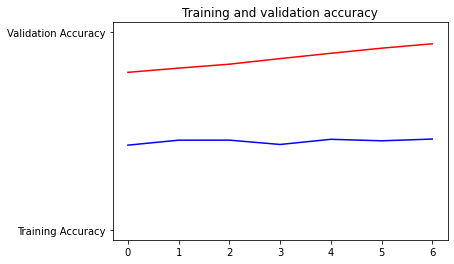

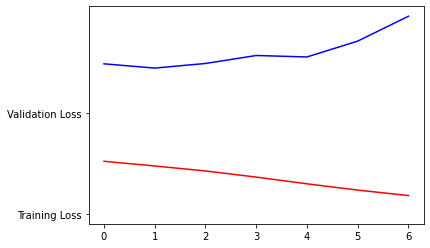

In [16]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")



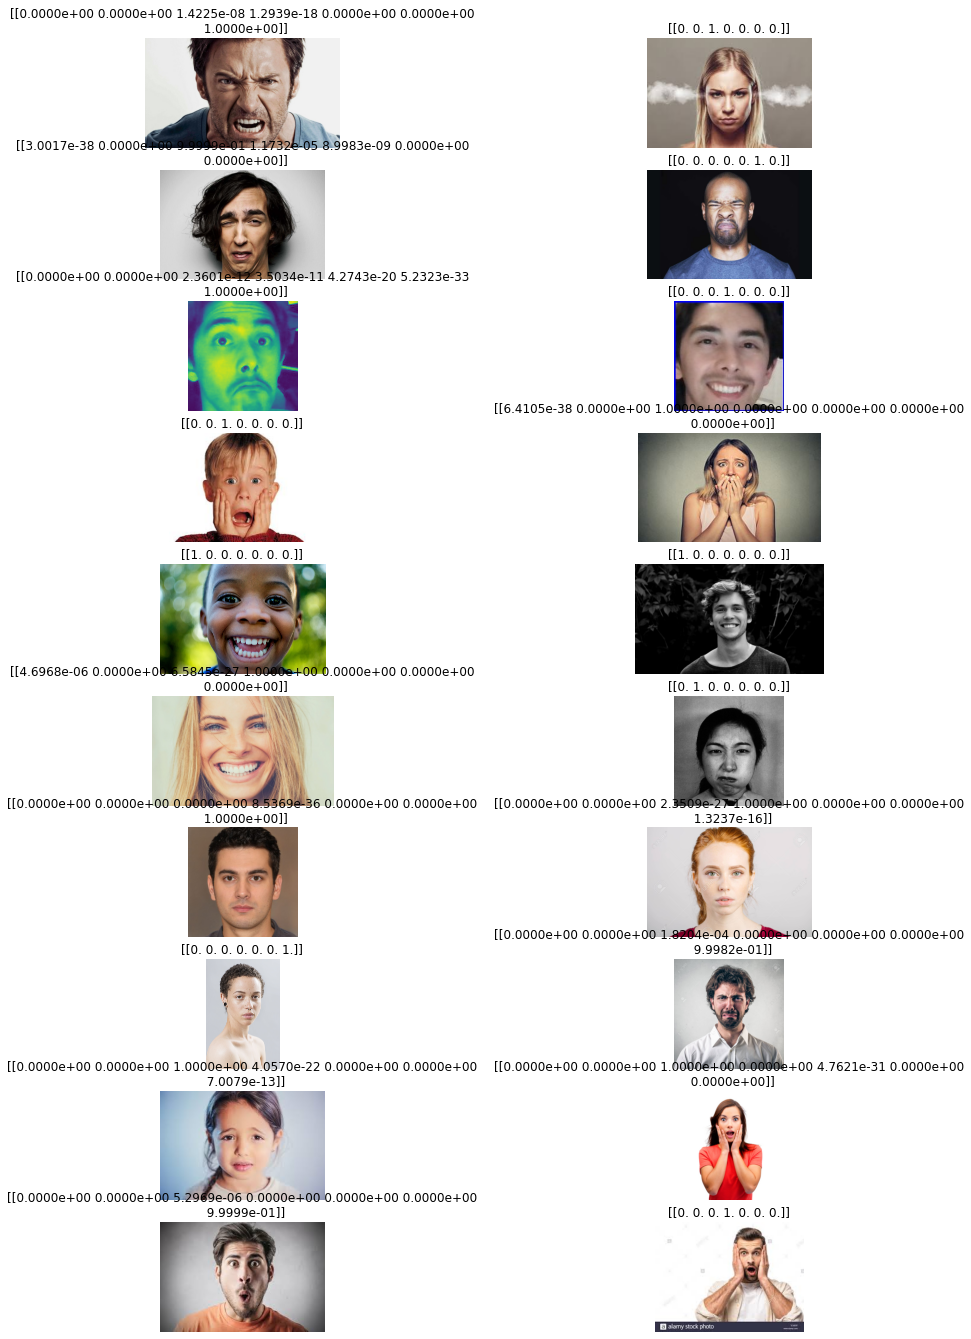

In [70]:
root_dir = "img_test"
dir_ = os.listdir(root_dir)

test_img_paths = [os.path.join(root_dir,x) for x in dir_]
rows = len(dir_)

fig = plt.gcf()
fig.set_size_inches(16,48)
for i, img in enumerate(test_img_paths):
    img_load_for_test = image.load_img(img, target_size=(i_s,i_s))
    img_test = image.img_to_array(img_load_for_test)
    img_test = np.expand_dims(img_test, axis=0)
    title = model.predict(img_test)

    img_plot = mpimg.imread(img)
    sb = plt.subplot(20,2,i+1)
    sb.set_title(str(title))
    sb.axis("off")
    img_plot = mpimg.imread(img)
    plt.imshow(img_plot)
plt.show()


<Figure size 1152x3456 with 0 Axes>

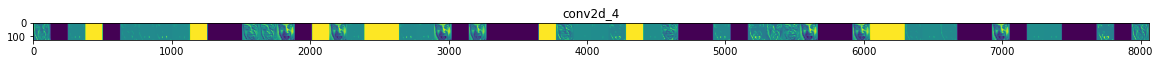

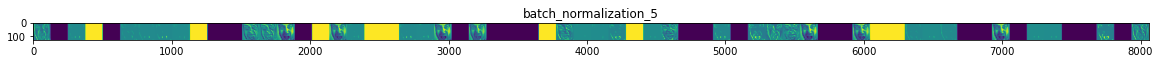

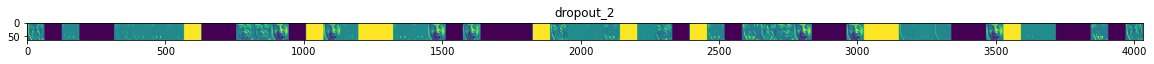

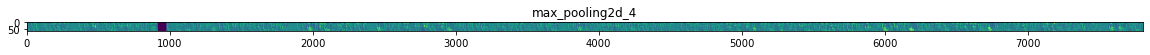

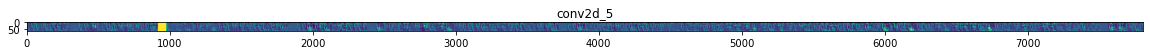

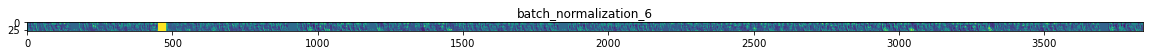

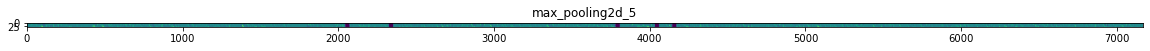

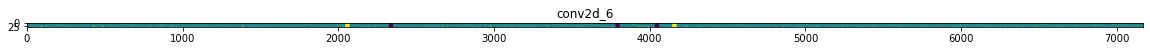

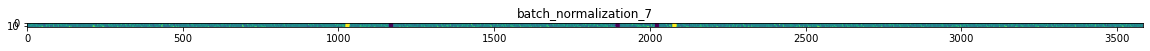

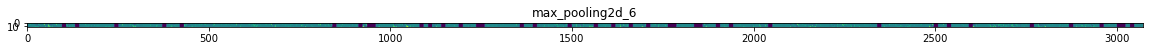

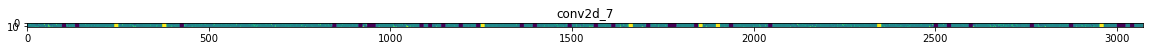

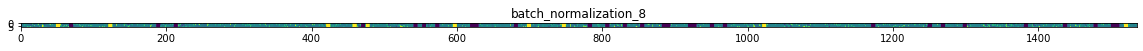

In [71]:

import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
abc = "emotions/test/anger"
abc_li = os.listdir(abc)
xyz = [os.path.join(abc, f) for f in abc_li]


img_path = random.choice(xyz)
img = load_img(img_path, target_size=(i_s, i_s))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
fig = plt.gcf()
fig.set_size_inches(16,48)
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis') 